In [2]:
import sys

sys.path.append("../src/")
from nnet import CRNN
#from pl_trainer import SEDTask4_2021
import pytorch_lightning as pl
from MT_trainer import CoSMo_benchmark
from utils.encoder import ManyHotEncoder
from utils.utils import batched_decode_preds
import scipy
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import torchaudio
import librosa
import librosa.display
import time
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import h5py
from IPython.display import Audio
from processing.sampler import ConcatDatasetBatchSampler
import torch
from tqdm import tqdm
import speechbrain as sb
import os
%matplotlib inline

2025-09-19 12:38:19.663537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-19 12:38:20.094131: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from processing.datasets import ConcatDatasetUrban, HDF5_dataset

In [49]:
with open("../config/sed_16k.yaml", "r") as f: #try to use sed_hear/ sed_bis previous
    conf = yaml.safe_load(f)

## Download SINGA-PURA & SONYC-UST-V2 Datasets via soundata

In [4]:
import soundata

dataset = soundata.initialize('singapura')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

INFO: Downloading ['audio', 'metadata', 'labels', 'index']. Index is being stored in /home/tianzichen/anaconda3/envs/CoSMo/lib/python3.8/site-packages/soundata/datasets/indexes, and the rest of files in /home/tianzichen/sound_datasets/singapura
INFO: /home/tianzichen/sound_datasets/singapura/labelled.zip already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: /home/tianzichen/sound_datasets/singapura/labelled.z01 already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: /home/tianzichen/sound_datasets/singapura/labelled.z02 already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.


KeyboardInterrupt: 

### Generate groundtruth embedding

In [5]:
with open(f"../config/taxonomy_SONYC.yaml", "r") as f:
    taxonomy_sn = yaml.safe_load(f)

with open(f"../config/taxonomy_SINGA-PURA.yaml", "r") as f:
    taxonomy_sgp = yaml.safe_load(f)


taxonomy_coarse_sn = taxonomy_sn["coarse"]
taxonomy_fine_sn = taxonomy_sn["fine"]
taxonomy_coarse_sgp = taxonomy_sgp["coarse"]
taxonomy_fine_sgp = taxonomy_sgp["fine"]

encoder_fine_sn = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=True,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder_coarse_sn = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder_fine_sgp = ManyHotEncoder(
    taxonomy_sgp,
    use_taxo_fine=True,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
encoder_coarse_sgp = ManyHotEncoder(
    taxonomy_sgp,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)

In [47]:
def generateSGPGroundtruthEmbedding(encoder, hdf5_path, csv_root):
    with h5py.File(hdf5_path, "r+") as hf:
        # 创建目标组（若不存在）
        if "SINGA-PURA" not in hf:
            sgp_grp = hf.create_group("SINGA-PURA" )
        else:
            sgp_grp = hf["SINGA-PURA"]

        # 创建groundtruth组
        if "groundtruth" not in sgp_grp:
            grp = sgp_grp.create_group("groundtruth")
        else:
            grp = sgp_grp["groundtruth"]
    
        # 读取SINGA-PURA的filenames
        dset = hf["SINGA-PURA/filenames"]
        filenames = [f.decode() for f in dset[:]]  # 解码字节字符串
        
        # 预分配矩阵内存
        n_samples = len(filenames)
        n_classes = len(encoder.taxonomy["class_labels"])
        n_frames = encoder.n_frames
        label_matrix = np.zeros((n_samples, n_classes, n_frames), dtype=np.float32)

        # 遍历每个音频文件
        for idx, h5_fname in enumerate(tqdm(filenames)):
            # 1. 解析CSV路径
            base_name = os.path.splitext(os.path.basename(h5_fname))[0]  # 从"date/name.flac"提取name
            csv_path = os.path.join(csv_root, f"{base_name}.csv")
            
            if not os.path.exists(csv_path):
                raise FileNotFoundError(f"CSV文件缺失: {csv_path}")

            # 2. 读取CSV并过滤列
            df = pd.read_csv(csv_path)
            required_cols = ["event_label", "onset", "offset"]
            if not set(required_cols).issubset(df.columns):
                raise ValueError(f"CSV文件缺少必要列: {csv_path}")
            df = df[required_cols]

            # 3. 编码为coarse标签矩阵
            encoded = encoder.encode_strong_df(df, dset="SINGA-PURA")  # 指定数据集类型
            label_matrix[idx] = encoded.T  # 转置为[n_classes, n_frames]

        # 4. 写入HDF5
        grp.create_dataset(
            name=encoder.taxonomy["name"],  # 例如"coarse"
            data=label_matrix,
            dtype=np.float64,
        )

In [31]:
hdf5_path = conf["data"]["root_path"] + conf["data"]["hdf5_test"]
csv_root = conf["data"]["raw_singa-pura_csv_root"]
generateSGPGroundtruthEmbedding(encoder_coarse_sgp, hdf5_path, csv_root )
generateSGPGroundtruthEmbedding(encoder_coarse_sn, hdf5_path, csv_root)
generateSGPGroundtruthEmbedding(encoder_fine_sgp, hdf5_path, csv_root)
generateSGPGroundtruthEmbedding(encoder_fine_sn, hdf5_path, csv_root)

100%|██████████| 1376/1376 [00:02<00:00, 618.37it/s]


In [48]:
# groundtruth .csv file contains both fine and coarse labels
def generateSonycGroundtruthEmbedding(coarse_encoder, fine_encoder, hdf5_path, split_csv_path):
       # 读取HDF5中的文件名
    with h5py.File(hdf5_path, "r+") as hf:
        filenames = [os.path.splitext(os.path.basename(f.decode()))[0] 
                    for f in hf["SONYC/filenames"][:]]  # 提取基本名称

    # 读取CSV并建立文件名映射
    df = pd.read_csv(split_csv_path)
    csv_mapping = {os.path.splitext(row.filename)[0]: row.event_labels
                  for _, row in df.iterrows()}

    # 预分配标签矩阵
    n_samples = len(filenames)
    n_coarse_class = len(coarse_encoder.taxonomy["class_labels"])
    n_fine_class = len(fine_encoder.taxonomy["class_labels"])
    coarse_labels = np.zeros((n_samples, n_coarse_class), dtype=np.float64)   # SONYC coarse有8类
    fine_labels = np.zeros((n_samples, n_fine_class), dtype=np.float64)    # SONYC fine有29类

    # 处理每个样本
    for idx, base_name in enumerate(tqdm(filenames)):
        # 获取标签字符串
        label_str = csv_mapping.get(base_name, "")
        if label_str == "0" or not label_str:
            continue  # 无标注数据

        # 分离coarse/fine标签
        current_coarse = []
        current_fine = []
        for label in label_str.split(';'):
            if '-' in label:
                # Fine标签处理 (如1-3)
                coarse_part = label.split('-')[0]
                current_coarse.append(coarse_part)
                current_fine.append(label)
            elif label.isdigit() and label != '0':
                # 纯coarse标签 (如7)
                current_coarse.append(label)

        # 编码标签
        coarse_vec = coarse_encoder.encode_weak(current_coarse, dset="SONYC")
        fine_vec = fine_encoder.encode_weak(current_fine, dset="SONYC")

        # 填充矩阵
        coarse_labels[idx] = coarse_vec
        fine_labels[idx] = fine_vec

    # 写入HDF5
    with h5py.File(hdf5_path, "r+") as hf:
        # 创建目标组（若不存在）
        if "SONYC" not in hf:
            sonyc_grp = hf.create_group("SONYC" )
        else:
            sonyc_grp = hf["SONYC"]

        # 创建groundtruth组
        if "groundtruth" not in sonyc_grp:
            grp = sonyc_grp.create_group("groundtruth")
        else:
            grp = sonyc_grp["groundtruth"]
        
        
        # 创建新数据集
        grp.create_dataset(
            coarse_encoder.taxonomy["name"],
            data=coarse_labels,
            dtype=np.float64,
        )
        grp.create_dataset(
            fine_encoder.taxonomy["name"],
            data=fine_labels,
            dtype=np.float64,
        )

    

In [56]:
hdf5_path = conf["data"]["root_path"] + conf["data"]["hdf5_test"]
split_csv_path = conf["data"]["root_path"] + conf["data"]["sonyc_csv_test"]
generateSonycGroundtruthEmbedding(encoder_coarse_sn, encoder_fine_sn, hdf5_path, split_csv_path)
generateSonycGroundtruthEmbedding(encoder_coarse_sgp, encoder_fine_sgp, hdf5_path, split_csv_path)

100%|██████████| 664/664 [00:00<00:00, 138558.10it/s]


#### A small tool to remove wrong group in HDF5 file

In [50]:
def delete_hdf5_group(hdf5_path, group_path):
    try:
        # 以读写模式打开HDF5文件
        with h5py.File(hdf5_path, "r+") as f:
            # 检查group是否存在
            if group_path in f:
                del f[group_path]
                print(f"成功删除组: {group_path}")
            else:
                print(f"警告: 组 {group_path} 不存在")
    except Exception as e:
        print(f"操作失败: {str(e)}")

In [57]:
hdf5_path = conf["data"]["root_path"] + conf["data"]["hdf5_test"]
delete_hdf5_group(hdf5_path, "SONYC/groundtruth_with_proximity")

成功删除组: SONYC/groundtruth_with_proximity


### Compute fine to coarse taxonomy matrix

In [5]:
import torchmetrics

torchmetrics.__version__

'1.1.2'

In [6]:
encoder = encoder_fine_sgp
classes_fine = encoder.taxonomy_fine["class_labels"]
classes_coarse = encoder.taxonomy_coarse["class_labels"]
t_matrix = np.zeros((len(classes_fine), len(classes_coarse)))

for k in encoder.taxonomy_fine["SONYC"].keys():
    c_fine = encoder.taxonomy_fine["SONYC"][k]
    if c_fine == "no-annotation":
        continue
    c_coarse = encoder.taxonomy_coarse["SONYC"][k]
    idx_fine = classes_fine.index(c_fine)
    idx_coarse = classes_coarse.index(c_coarse)

    t_matrix[idx_fine, idx_coarse] = 1

for k in encoder.taxonomy_fine["SINGA-PURA"].keys():
    c_fine = encoder.taxonomy_fine["SINGA-PURA"][k]
    c_coarse = encoder.taxonomy_coarse["SINGA-PURA"][k]
    if c_fine == "no-annotation":
        continue
    idx_fine = classes_fine.index(c_fine)
    idx_coarse = classes_coarse.index(c_coarse)

    t_matrix[idx_fine, idx_coarse] = 1

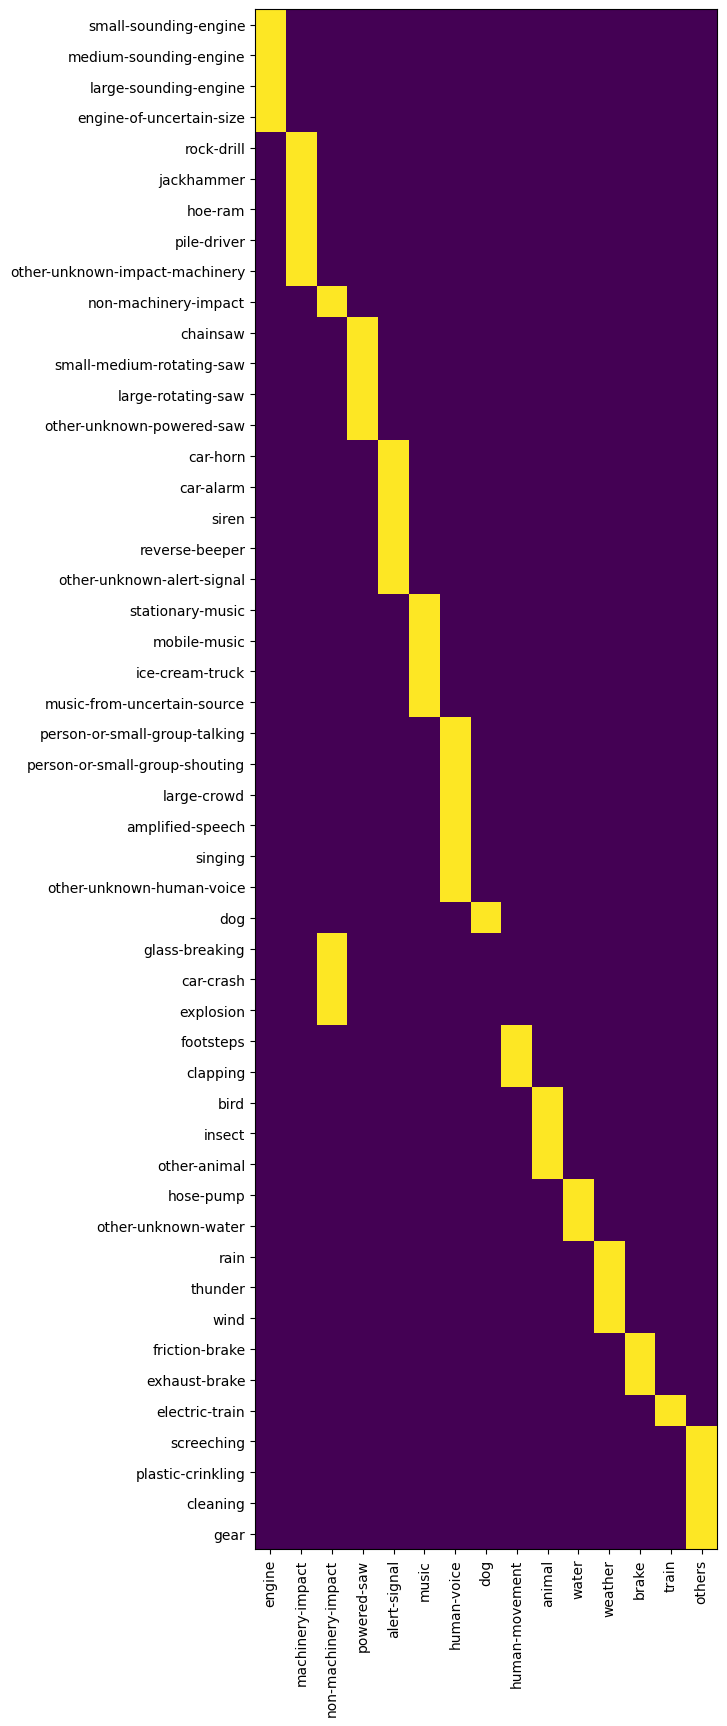

In [7]:
plt.figure(figsize=(20, 20))
plt.xticks(ticks=range(len(classes_coarse)), labels=classes_coarse, rotation="vertical")
plt.yticks(ticks=range(len(classes_fine)), labels=classes_fine)
plt.imshow(t_matrix)
plt.show()

### Compute time streching matrix

In [8]:
encoder = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
print(encoder.n_frames)

156


In [9]:
encoder2 = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=415,
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
print(encoder2.n_frames)

192


In [10]:
encoder3 = ManyHotEncoder(
    taxonomy_sn,
    use_taxo_fine=False,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=830,
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)
print(encoder3.n_frames)

96


In [11]:
def get_rescale_matrix(encoder_in, encoder_out):

    if encoder_in.n_frames == encoder_out.n_frames:
        return np.eye(encoder_in.n_frames, encoder_out.n_frames)
    decim = np.ceil(encoder_out.n_frames / encoder_in.n_frames).astype(int)
    r_matrix = torch.zeros(encoder_in.n_frames, encoder_out.n_frames * decim)
    for i in range(r_matrix.shape[1]):
        lookup = min(
            encoder_in.n_frames - 1,
            int(encoder_in._time_to_frame(decim * encoder_out._frame_to_time(i))),
        )
        r_matrix[lookup, i] = 1

    return r_matrix[:, ::decim]

In [12]:
def get_rescale_matrix(encoder_in, encoder_out):

    if encoder_in.n_frames == encoder_out.n_frames:
        return np.eye(encoder_in.n_frames, encoder_out.n_frames)
    elif encoder_in.n_frames >= encoder_out.n_frames:
        coarse_encoder = encoder_out
        fine_encoder = encoder_in
        transpose = True
    else:
        fine_encoder = encoder2
        coarse_encoder = encoder_in
        transpose = False

    r_matrix = torch.zeros(coarse_encoder.n_frames, fine_encoder.n_frames)
    for i in range(r_matrix.shape[1]):
        lookup = min(
            coarse_encoder.n_frames - 1,
            int(coarse_encoder._time_to_frame(fine_encoder._frame_to_time(i))),
        )
        r_matrix[lookup, i] = 1

    return r_matrix.T if transpose else r_matrix

In [13]:
r_matrix1 = get_rescale_matrix(encoder, encoder2).numpy()
r_matrix2 = get_rescale_matrix(encoder2, encoder3).numpy()
r_matrix3 = get_rescale_matrix(encoder, encoder3).numpy()

In [14]:
r_matrix_bis = get_rescale_matrix(encoder, encoder3).numpy()

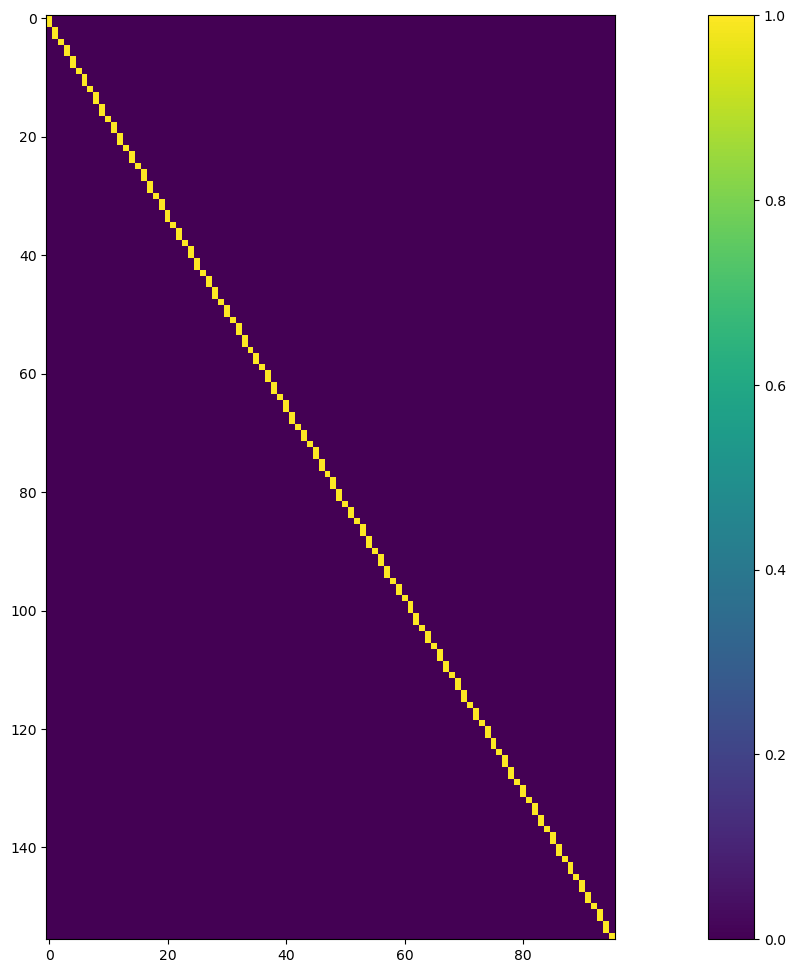

In [15]:
plt.figure(figsize=(24, 12))
plt.imshow(r_matrix_bis)
plt.colorbar()

In [16]:
hdf5_path = conf["data"]["root_path"] + conf["data"]["hdf5_train"]
with h5py.File(hdf5_path, "r") as hf:
    print(hf["SINGA-PURA"]["filenames"][10])
    print(hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][10])

b'2020-08-25/[b827ebb954cd][2020-08-25T16-53-04Z][manual][---][de313d12d7f31937615be80cc47a1ad9][]-1166.flac'
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Test torchmetrics

In [17]:
import torchmetrics

f1_macro = torchmetrics.F1Score(
    task='multiclass',  # can be 'binary' 'multilabel'  'multiclass'
    num_classes=len(encoder_coarse_sn.labels), 
    average="macro", threshold=0.5
)

f1_weighted = torchmetrics.F1Score(
    task='multiclass',
    num_classes=len(encoder_coarse_sn.labels), 
     average="weighted", threshold=0.5
)

auroc_macro = torchmetrics.AUROC(
    task='multiclass',
    num_classes=len(encoder_coarse_sn.labels), 
    average="macro",
)

auroc_weighted = torchmetrics.AUROC(
    task='multiclass',
    num_classes=len(encoder_coarse_sn.labels), 
    average="weighted",
)

ap_macro = torchmetrics.AveragePrecision(
    task='multiclass',
    num_classes=len(encoder_coarse_sn.labels),
    average="macro", # "micro" previously7
)

ap_weighted = torchmetrics.AveragePrecision(
    task='multiclass',
    num_classes=len(encoder_coarse_sn.labels),
    average="weighted",
)


label_ranking = torchmetrics.LabelRankingAveragePrecision()

weak_metrics = torchmetrics.MetricCollection(
    {
        "micro_F1_score": f1_macro,
        "weighted_F1_score": f1_weighted,
        "auroc_micro": auroc_macro,
        "auroc_weighted": auroc_weighted,
        "ap_micro": ap_macro,
        "ap_weighted": ap_weighted,
        "label_ranking": label_ranking,
    }
)

roc_curve = torchmetrics.ROC(num_classes=len(encoder_coarse_sn.labels), pos_label=1)

pr_curve = torchmetrics.PrecisionRecallCurve(
    num_classes=len(encoder_coarse_sn.labels), pos_label=1
)

weak_metric_curves = torchmetrics.MetricCollection(
    {
        "roc_curve": roc_curve,
        "pr_curve": pr_curve,
    }
)

AttributeError: module 'torchmetrics' has no attribute 'LabelRankingAveragePrecision'

In [ ]:
preds = torch.rand(500, len(encoder_coarse_sn.labels))
targets = torch.randint(2, (500, len(encoder_coarse_sn.labels)))

weak_metric_curves.update(preds, targets)

In [ ]:
res = weak_metric_curves.compute()

In [ ]:
fpr, tpr, thresh = res["roc_curve"]

In [ ]:
fpr[0].shape

### HDF5 Dataset

In [18]:
SINGAPURA_train_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"], "SINGA-PURA", encoder
)
SONYC_train_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"], "SONYC", encoder
)
SINGAPURA_val_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"], "SINGA-PURA", encoder
)
unlabelled_SINGAPURA_train_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"],
    "unlabelled_SINGA-PURA",
    encoder,
)
SONYC_val_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"], "SONYC", encoder
)
SINGAPURA_test_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"], "SINGA-PURA", encoder
)
SONYC_test_set = HDF5_dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"], "SONYC", encoder
)


In [19]:
batch_sizes = conf["training"]["batch_size"]
batch_sizes = [8, 16, 24]
bs = []
tot_train_data = []
if batch_sizes[0] > 0:
    tot_train_data.append(SINGAPURA_train_set)
    bs.append(batch_sizes[0])
if batch_sizes[1] > 0:
    tot_train_data.append(SONYC_train_set)
    bs.append(batch_sizes[1])
if batch_sizes[2] > 0:
    tot_train_data.append(unlabelled_SINGAPURA_train_set)
    bs.append(batch_sizes[2])


samplers = [torch.utils.data.RandomSampler(x) for x in tot_train_data]
train_dataset = ConcatDatasetUrban(tot_train_data, encoder, batch_sizes=batch_sizes)
if len(bs) > 1:
    batch_sampler = ConcatDatasetBatchSampler(samplers, bs)
else:
    batch_sampler = torch.utils.data.BatchSampler(samplers[0], bs[0], drop_last=True)

valid_dataset = ConcatDatasetUrban(
    [SINGAPURA_val_set, SONYC_val_set], encoder, [conf["training"]["batch_size_val"]]
)

test_dataset = ConcatDatasetUrban(
    [SINGAPURA_test_set, SONYC_test_set], encoder, [conf["training"]["batch_size_val"]]
)

In [20]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_sampler=batch_sampler,
    collate_fn=train_dataset.collate_fn,
    num_workers=4,
)

val_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=conf["training"]["batch_size_val"],
    num_workers=4,
    shuffle=False,
    drop_last=False,
    collate_fn=valid_dataset.collate_fn,
)

In [21]:
loader = train_loader if 1 else val_loader
dataiter = iter(loader)

#### Show class count in every set

总共统计了 35 个声音事件类别
已保存图表: sonyc_test_event_distribution.png


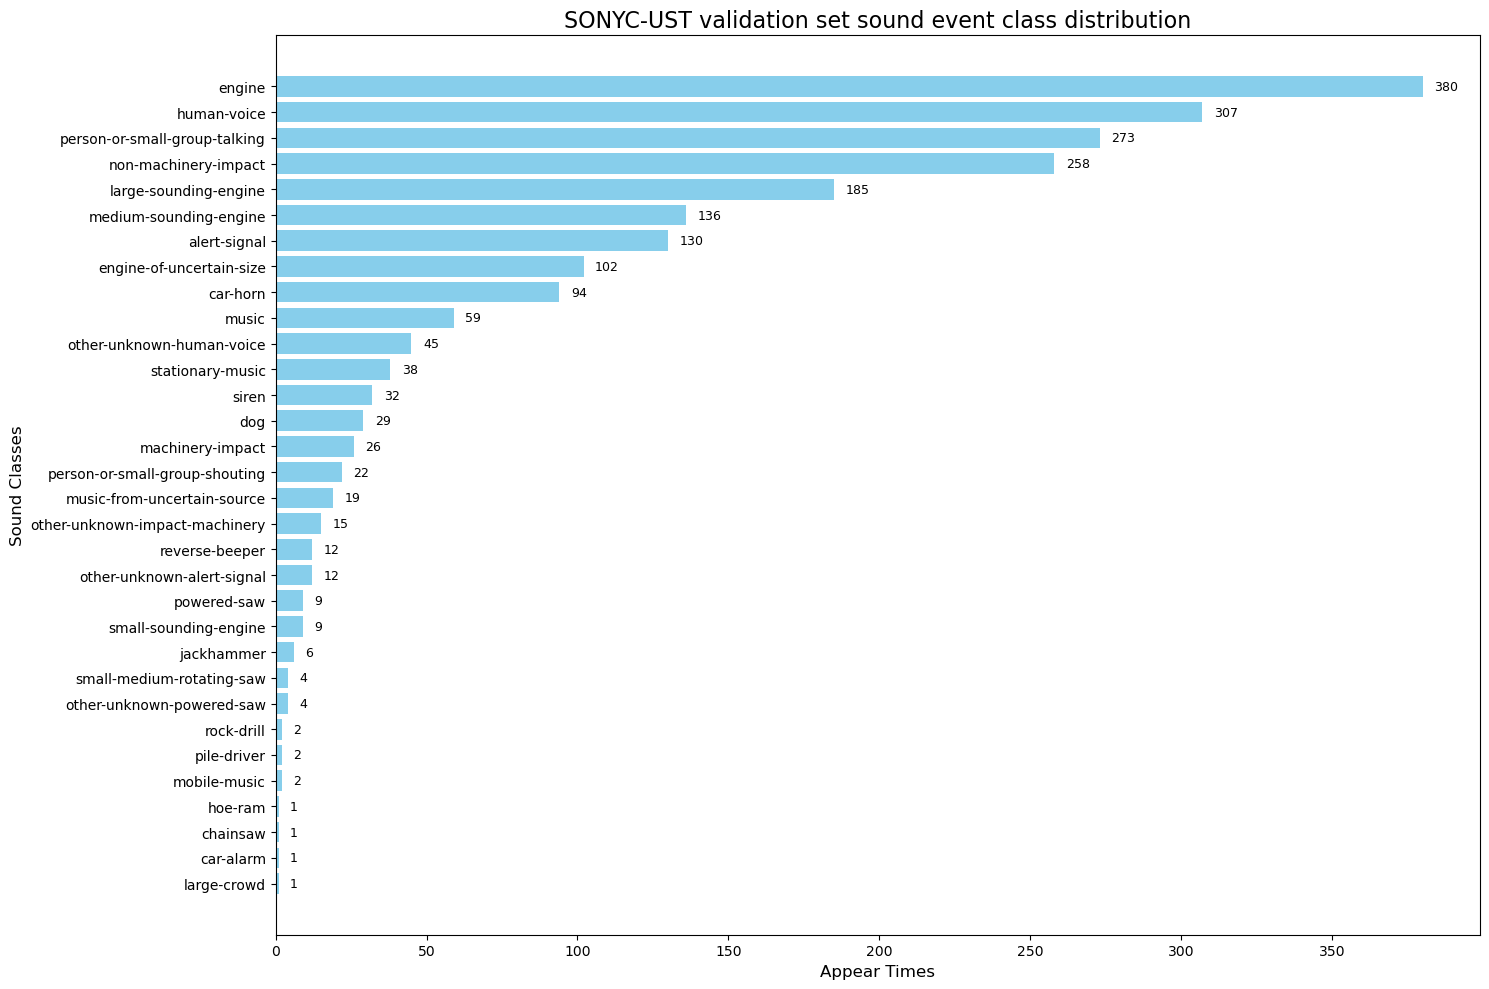

In [44]:
coarse_encoder = encoder_coarse_sn
fine_encoder = encoder_fine_sn
hdf5_path = conf["data"]["root_path"] + conf["data"]["hdf5_test"]
# 读取HDF5文件中的groundtruth数据
with h5py.File(hdf5_path, 'r') as hf:
    coarse_labels = hf['/SONYC/groundtruth/taxonomy_coarse_SONYC'][:]
    fine_labels = hf['/SONYC/groundtruth/taxonomy_fine_SONYC'][:]
    
    # 获取文件名列表
    filenames = [os.path.splitext(f.decode())[0] 
                 for f in hf['SONYC/filenames'][:]]

# 统计粗粒度类别出现次数
coarse_counts = np.sum(coarse_labels, axis=0)
coarse_count_dict = {label: int(count) 
                     for label, count in zip(coarse_encoder.labels, coarse_counts)}

# 统计细粒度类别出现次数
fine_counts = np.sum(fine_labels, axis=0)
fine_count_dict = {label: int(count) 
                   for label, count in zip(fine_encoder.labels, fine_counts)}

# 合并统计结果
all_counts = {**coarse_count_dict, **fine_count_dict}
print(f"总共统计了 {len(all_counts)} 个声音事件类别")

# 过滤掉"no-annotation"类别
filtered_counts = {k: v for k, v in all_counts.items() if k != "no-annotation" and v > 0}

# 按出现次数排序
sorted_counts = dict(sorted(filtered_counts.items(), key=lambda item: item[1], reverse=True))

# 绘制直方图
plt.figure(figsize=(15, 10))

# 创建水平条形图（更适合长类别名称）
bars = plt.barh(
    list(sorted_counts.keys()), 
    list(sorted_counts.values()),
    color='skyblue'
)

# 添加数据标签
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(sorted_counts.values())*0.01, 
             bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', 
             ha='left', va='center',
             fontsize=9)

plt.xlabel('Appear Times', fontsize=12)
plt.ylabel('Sound Classes', fontsize=12)
plt.title('SONYC-UST validation set sound event class distribution', fontsize=16)
plt.gca().invert_yaxis()  # 反转Y轴使最高值在顶部
plt.tight_layout()

# 保存图表
plt.savefig('sonyc_test_event_distribution.png', dpi=300, bbox_inches='tight')
print("已保存图表: sonyc_test_event_distribution.png")

# 显示图表
plt.show()

### Test Audio Normalization and PCEN/Leaf from Speechbrain

In [22]:
from utils.scaler import TorchScaler

feat_params = conf["features"]
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=feat_params["sample_rate"],
    n_fft=feat_params["n_window"],
    win_length=feat_params["n_window"],
    hop_length=feat_params["hop_length"],
    center=True,
    pad_mode="reflect",
    power=1.0,
    f_min=feat_params["f_min"],
    f_max=feat_params["f_max"],
    n_mels=feat_params["n_mels"],
    window_fn=torch.hamming_window,
    norm="slaney",
    onesided=True,
    mel_scale="htk",
)

/home/tianzichen/anaconda3/envs/CoSMo/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [23]:
def take_log(mels):
    """Apply the log transformation to mel spectrograms.
    Args:
        mels: torch.Tensor, mel spectrograms for which to apply log.

    Returns:
        Tensor: logarithmic mel spectrogram of the mel spectrogram given as input
    """

    return (1e-5 + mels).log()

    # amp_to_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude")
    # amp_to_db.amin = 1e-5  # amin= 1e-5 as in librosa
    # return amp_to_db(mels)#.clamp(min=-50, max=120)  # clamp to reproduce old code

In [24]:
scaler = TorchScaler(batch_sizes, "instance", "standard", (2,))

In [25]:
batch = next(dataiter)

In [26]:
audio, labels, filenames = batch
features = mel_spec(audio)

In [27]:
logfeat = take_log(features)

In [28]:
indx_strong, indx_weak, indx_unlab = batch_sizes
batch_num = features.shape[0]
# deriving masks for each dataset
mask_strong = torch.zeros(batch_num).to(features).bool()
mask_weak = torch.zeros(batch_num).to(features).bool()
mask_unlab = torch.zeros(batch_num).to(features).bool()
mask_strong[:indx_strong] = 1
mask_weak[indx_strong : indx_weak + indx_strong] = 1
if indx_unlab > 0:
    mask_unlab[indx_strong + indx_weak :] = 1

In [29]:
def normalize(tensor, type_mask):
    dims = (2,)
    if type_mask == "strong":
        return tensor - torch.mean(tensor, dims, keepdim=True)
    elif type_mask == "weak":
        return (tensor - torch.mean(tensor, dims, keepdim=True)) / (
            torch.std(tensor, dims, keepdim=True) + 1e-15
        )
    elif type_mask == "unlab":
        return (tensor - torch.amin(tensor, dim=dims, keepdim=True)) / (
            torch.amax(tensor, dim=dims, keepdim=True)
            - torch.amin(tensor, dim=dims, keepdim=True)
            + 1e-15
        )


tensor = logfeat.clone()
if torch.any(mask_strong):
    tensor[mask_strong] = normalize(tensor[mask_strong], "strong")
if torch.any(mask_weak):
    tensor[mask_weak] = normalize(tensor[mask_weak], "weak")
if torch.any(mask_unlab):
    tensor[mask_unlab] = normalize(tensor[mask_unlab], "unlab")

In [30]:
logfeat_scaled = logfeat.clone()
logfeat_scaled = scaler(logfeat_scaled, mask_strong, mask_weak, mask_unlab)

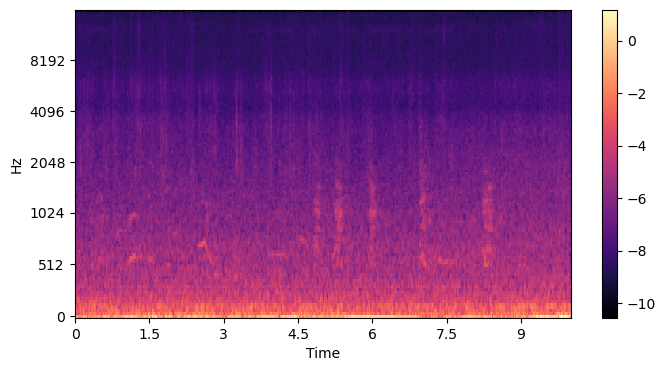

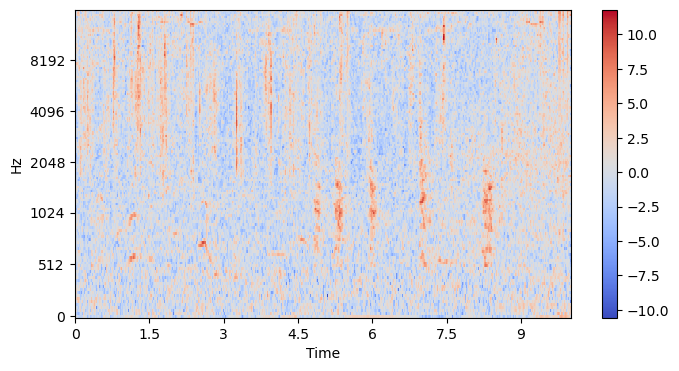

In [31]:
idx = 11

fig, ax = plt.subplots(figsize=(8, 4))
img = librosa.display.specshow(
    logfeat[idx].numpy(), x_axis="time", y_axis="mel", sr=32000, fmax=16000, ax=ax
)
fig.colorbar(img, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
img = librosa.display.specshow(
    logfeat_scaled[idx].numpy(),
    x_axis="time",
    y_axis="mel",
    sr=32000,
    fmax=16000,
    ax=ax,
)
fig.colorbar(img, ax=ax)
plt.show()


Audio(audio[idx], rate=32000)

In [32]:
print(features[0, 0, 0], features[26, 50, 50], features[14, 50, 50])
print(logfeat[0, 50, 50], logfeat[28, 50, 50], logfeat[14, 50, 50])
print(logfeat_scaled[0, 50, 50], logfeat_scaled[28, 50, 50], logfeat_scaled[14, 50, 50])

tensor(0.0248) tensor(0.0018) tensor(0.0048)
tensor(-7.8120) tensor(-9.1620) tensor(-5.3437)
tensor(-1.6209) tensor(-2.7041) tensor(0.0330)


In [33]:
scaler.fit(
    train_loader,
    transform_func=lambda x: take_log(mel_spec(x[0])),
)

  0%|          | 0/529 [00:00<?, ?it/s]


AttributeError: 'TorchScaler' object has no attribute 'device'

In [ ]:
batch = dataiter.next()
enter_while = False
while batch[2][0][0] == "[" and enter_while:
    enter_while = False
    batch = dataiter.next()

In [ ]:
audio, labels, filenames = batch
audio = audio.cuda()

### Test torchopenl3 and CRNN inference

In [ ]:
resampler = torchaudio.transforms.Resample(32000, 48000, dtype=audio.dtype).cuda()
audio_res = resampler(audio).cuda()

In [ ]:
audio_res1 = audio_res

In [35]:
import torchopenl3

In [36]:
model_openl3 = torchopenl3.models.load_audio_embedding_model(
    input_repr="mel256", content_type="env", embedding_size=512
).cuda()

/home/tianzichen/anaconda3/envs/CoSMo/lib/python3.8/site-packages/torchopenl3/models.py:200: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = librosa.filters.mel(
Downloading: "https://github.com/torchopenl3/torchopenl3-models/raw/master/torchopenl3_mel256_env_512.pth.tar" to /home/tianzichen/.cache/torch/hub/checkpoints/torchopenl3_mel256_env_512.pth.tar


URLError: <urlopen error [Errno 110] Connection timed out>

In [ ]:
emb, ts = torchopenl3.get_audio_embedding(
    audio_res, sr=48000, model=model, hop_size=0.0615
)

In [ ]:
emb.shape

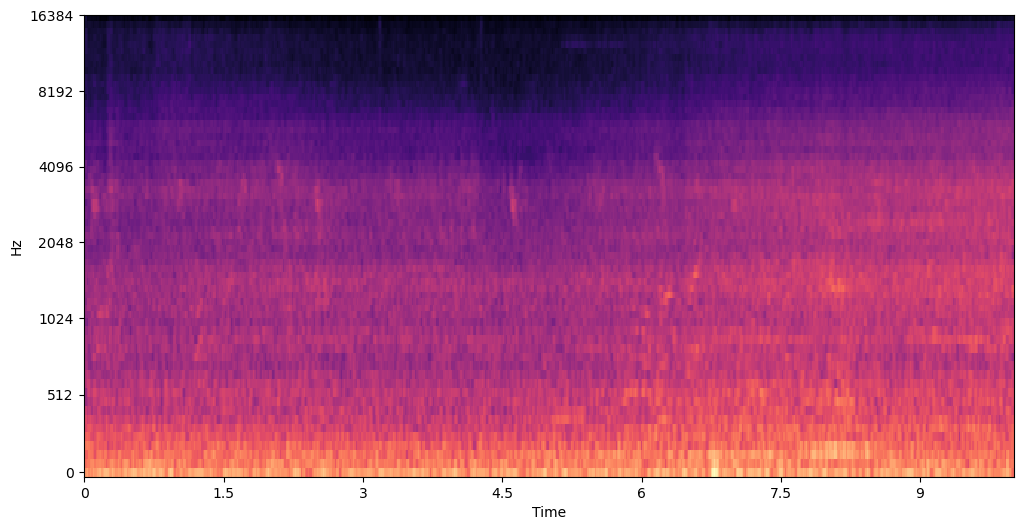

In [33]:
idx = 8
y = audio[idx].numpy()
feat_params = conf["features"]

mel_spec_2 = torchaudio.transforms.MelSpectrogram(
    sample_rate=feat_params["sample_rate"],
    n_fft=feat_params["n_window"],
    win_length=feat_params["n_window"],
    hop_length=feat_params["hop_length"],
    center=True,
    pad_mode="reflect",
    power=2.0,
    f_min=feat_params["f_min"],
    f_max=feat_params["f_max"],
    n_mels=int(feat_params["n_mels"] / 2),
    window_fn=torch.hamming_window,
    norm="slaney",
    onesided=True,
    mel_scale="htk",
)

mel_spec_librosa = mel_spec_2(torch.from_numpy(y).float()).numpy()

librosa_dB = librosa.power_to_db(mel_spec_librosa, ref=np.max)

pcen_spec = sb.nnet.normalization.PCEN(
    input_size=feat_params["n_mels"],
    trainable=False,
    alpha=0.8,
    delta=10,
    root=0.25,
    floor=1e-6,
    smooth_coef=0.02,  # i.e. T=800ms
)

fig, ax = plt.subplots(figsize=(12, 6))
librosa.display.specshow(
    librosa_dB, x_axis="time", y_axis="mel", sr=32000, fmax=16000, ax=ax
)

Audio(y, rate=32000)

In [37]:
conf["net"].update({"n_class": len(encoder.labels)})
conf.update({"taxonomy": encoder.taxonomy["name"]})
print(encoder.taxonomy["name"])
print(len(encoder.labels))

taxonomy_coarse_SONYC
8


In [40]:
print(torch.__version__, pl.__version__)

2.0.1 1.5.1


In [38]:
path_ckpt = "../experiments/COSMO/[8, 16, 24]_[095, 01, 0]_log+pcen_SONYC_weak/version_5/epoch=169-step=89929.ckpt"
sed_student = CRNN.CRNN(**conf["net"])
print(sed_student.parameters())
model = CoSMo_benchmark.load_from_checkpoint(
    path_ckpt, encoder=encoder, sed_student=sed_student, hparams=conf
)


<generator object Module.parameters at 0x7f76b86ba190>


AttributeError: 'dict' object has no attribute 'add_param_group'

In [39]:
fp16_model = model.half
torch.onnx.export(fp16_model)

In [47]:
with torch.no_grad():
    strong_pred, weak_pred = model(audio)

RuntimeError: Given groups=1, weight of size [16, 2, 3, 3], expected input[48, 1, 626, 128] to have 2 channels, but got 1 channels instead

In [39]:
print(filenames[idx])
print(encoder.decode_strong(labels[idx].numpy()))
gt = val_loader.dataset.datasets[0].groundtruths
print(gt[gt["filename"] == filenames[idx]][["onset", "offset", "event_label"]])

16_016806.wav
[['engine', 0.0, 0.064], ['machinery-impact', 0.0, 0.064], ['powered-saw', 0.0, 0.064], ['human-voice', 0.0, 0.064]]
Empty DataFrame
Columns: [onset, offset, event_label]
Index: []


In [49]:
plt.figure(figsize=(20, 5))
plt.plot(weak_pred[idx])
plt.xticks(
    labels=map(lambda x: x[:13], encoder.labels),
    ticks=list(range(len(encoder.labels))),
    fontsize=15,
)
plt.yticks(fontsize=15)
plt.show()

NameError: name 'weak_pred' is not defined

<Figure size 2000x500 with 0 Axes>

In [50]:
for i, label in enumerate(encoder.labels):
    plt.figure()
    plt.plot(strong_pred[idx, i, :].numpy())
    plt.title(label)
    plt.ylim([0, 1])

NameError: name 'strong_pred' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
filenames_strong = [x for x in filenames if x[0] == "["]
mask_strong = torch.tensor([x[0] == "[" for x in filenames], device=model.device).bool()

In [ ]:
decoded_pred = batched_decode_preds(
    strong_pred[mask_strong],
    filenames_strong,
    model.encoder,
    median_filter=model.hparams["training"]["median_window"],
    thresholds=list(model.val_buffer_student_strong.keys()),
)
df = decoded_pred[0.5]
print("predictions : ")
print(df[df["filename"] == filenames[idx]][["onset", "offset", "event_label"]])
print("groundtruths :")
print(gt[gt["filename"] == filenames[idx]][["onset", "offset", "event_label"]])

In [ ]:
SINGAPURA_train_set = HDF5_SINGAPURA_labelled(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"],
    conf["data"]["root_path"] + conf["data"]["singa-pura_csv_train"],
    encoder,
    return_filename=True,
)

In [ ]:
hf = h5py.File(conf["data"]["root_path"] + conf["data"]["hdf5_train"], "r")

In [ ]:
for f in hf:
    print(f)

In [ ]:
for d in group["groundtruth"]:
    print(group["groundtruth"][d].shape)

## Computing proximity for SONYC

In [58]:
type_hf = "test"
# sonyc_gt = pd.read_csv((conf['data']["root_path"]+conf['data'][f"sonyc_csv_{type_hf}"]).replace(".csv","_extended.csv"))
# sonyc_df = pd.read_csv("../data/metadata/annotations_sonyc.csv")

In [7]:
n_unknown = 0
n_disagreement = 0
n_near = 0
n_far = 0

for i, row in tqdm(sonyc_gt.iterrows()):
    prox = row["proximity"]
    if isinstance(prox, float):
        continue
    prox = prox.split(";")
    n_unknown += prox.count("-1")
    n_disagreement += prox.count("ambiguous")
    n_near += prox.count("near")
    n_far += prox.count("far")

print(
    f"n_unknown = {n_unknown}, n_disagreement = {n_disagreement}, n_near = {n_near}, n_far = {n_far}"
)

NameError: name 'sonyc_gt' is not defined

In [ ]:
prox_col = sonyc_df.columns[41:70]
prox_ids = list(map(lambda x: x[:3], prox_col))

In [ ]:
for i, row in sonyc_gt.iterrows():
    labels = row["event_labels"].split(";")
    fine_labels = list(filter(lambda x: len(x) > 1, labels))
    assert len(fine_labels) > 0

In [ ]:
taxonomy_fine["SONYC"]["1-1"]

In [ ]:
"""
Pseudo code:

no proximity annotation : 1
near : 2
far : 3
ambiguous : 4


Parcourir le dataframe
    get filename
    get labels from metadata
    keep only fine labels
    
    for each fine labels (function):
        check proximity annotations other than -1 and notsure
        if only one : register this one
        if multiple : get max occurrence
        if two maximums : disagreement
        
        return [fine_labels, proximity]
    
    update with two new columns : fine_labels, proximity


"""


def merge_proximity_annot(l):
    n_near = l.count("near")
    n_far = l.count("far")

    if n_near == 0 and n_near == 0:
        return "-1"
    elif n_near > 0 and n_near > n_far:
        return "near"
    elif n_far > 0 and n_far > n_near:
        return "far"
    else:
        return "ambiguous"


proximity_list = [None] * len(sonyc_gt)
fine_labels_list = [None] * len(sonyc_gt)
for i, row in tqdm(sonyc_gt.iterrows()):
    filename = row["filename"]
    idx_label = row["event_labels"].split(";")
    indices_fine_label = list(filter(lambda x: len(x) > 1, idx_label))
    local_prox_list = []
    for if_fl in indices_fine_label:
        idx_col = prox_ids.index(if_fl)
        prox_annots = list(
            sonyc_df[sonyc_df["audio_filename"] == filename][prox_col[idx_col]]
        )
        local_prox_list.append(merge_proximity_annot(prox_annots))
    fine_labels_list[i] = ";".join(indices_fine_label)
    proximity_list[i] = ";".join(local_prox_list)

sonyc_gt["fine_labels"] = fine_labels_list
sonyc_gt["proximity"] = proximity_list
sonyc_gt.to_csv(
    (conf["data"]["root_path"] + conf["data"][f"sonyc_csv_{type_hf}"]).replace(
        ".csv", "_extended.csv"
    ),
    index=False,
)

In [ ]:
print(len(sonyc_df[sonyc_df["split"] == "test"]["audio_filename"].unique()))
print(
    len(
        sonyc_df[(sonyc_df["split"] == "test") & (sonyc_df["annotator_id"] == 0)][
            "audio_filename"
        ].unique()
    )
)

In [ ]:
sonyc_gt.to_csv(
    (conf["data"]["root_path"] + conf["data"][f"sonyc_csv_{type_hf}"]).replace(
        ".csv", "_extended.csv"
    ),
    index=False,
)

In [ ]:
sonyc_gt.to_csv(
    (conf["data"]["root_path"] + conf["data"][f"sonyc_csv_{type_hf}"]).replace(
        ".csv, _extended.csv"
    ),
    index=False,
)

In [ ]:
conf["data"]["root_path"] + conf["data"][f"sonyc_csv_{type_hf}"].replace(
    ".csv", "_extended.csv"
)

## Creating proximity groundtruths for SONYC in HDF5

In [75]:
hf.close()

In [72]:
type_hf = "test_16k"
# hf = h5py.File(conf["data"]["root_path"] + conf["data"][f"hdf5_{type_hf}"], 'r+')
# sgp_gt = pd.read_csv(f"../data/metadata/{type_hf}/SONYC_{type_hf}.csv")
hf = h5py.File(f"{conf['data']['root_path']}{type_hf}.h5", "r+")

In [73]:
def print_hf(hf):
    def recursive_print(hf, tab):
        for name in hf:
            if isinstance(hf[name], h5py.Group):
                print("".join(["\t"] * tab) + name)
                recursive_print(hf[name], tab + 1)
            else:
                print(
                    "".join(["\t"] * tab) + str(hf[name]).replace("<HDF5 dataset", "")
                )

    recursive_print(hf, 0)

In [74]:
print_hf(hf)

SINGA-PURA
	 "audio_32k": shape (1376, 160000), type "<f4">
	 "filenames": shape (1376,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (1376, 15, 78), type "<f8">
		 "taxonomy_coarse_SONYC": shape (1376, 8, 78), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (1376, 50, 78), type "<f8">
		 "taxonomy_fine_SONYC": shape (1376, 29, 78), type "<f8">
	groundtruth_with_proximity
		 "taxonomy_coarse_SINGA-PURA": shape (1376, 15, 78), type "<f8">
		 "taxonomy_coarse_SONYC": shape (1376, 8, 78), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (1376, 50, 78), type "<f8">
		 "taxonomy_fine_SONYC": shape (1376, 29, 78), type "<f8">
SONYC
	 "audio_32k": shape (664, 160000), type "<f4">
	 "filenames": shape (664,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (664, 15), type "<f8">
		 "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (664, 50), type "<f8">
		 "taxonomy_fine_SONYC": shape (664, 29), type "<f8">
	groundtruth

In [62]:
encoder_fine_sn.labels[1]

'medium-sounding-engine'

In [70]:
# right after copy find gt in right place with val=1.0 (2.0 expected)
idx = 91
print(hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_fine_SONYC"][idx])
print(hf["SONYC"]["filenames"][idx])
print(hf["SONYC"]["groundtruth"]["taxonomy_fine_SONYC"][idx])
print(sonyc_gt["filename"][idx])
print(sonyc_gt["proximity"][idx])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
b'05_027485.wav'
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
05_027485.wav
far


In [63]:
group_to_copy = hf["SONYC"]["groundtruth"]
group_dest = hf["SONYC"]
ok = input("proceed to copy group ?")
if ok == "y":
    hf.copy(group_to_copy, group_dest, "groundtruth_with_proximity")

In [64]:
for i in hf["SONYC"]["groundtruth_with_proximity"]:
    print(i)
gt_coarse_SGP = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_coarse_SINGA-PURA"]
gt_fine_SGP = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_fine_SINGA-PURA"]
gt_fine_SONYC = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_fine_SONYC"]
gt_coarse_SONYC = hf["SONYC"]["groundtruth_with_proximity"]["taxonomy_coarse_SONYC"]

taxonomy_coarse_SINGA-PURA
taxonomy_coarse_SONYC
taxonomy_fine_SINGA-PURA
taxonomy_fine_SONYC


In [65]:
def update_prox_one_hot(prev_value, prox):
    prox_to_label = {"-1": 1, "near": 2, "far": 3, "ambiguous": 4}
    if prev_value == 0:
        raise ValueError(f"Should not happen")
    elif prev_value == 1 or prev_value == prox_to_label[prox]:
        return prox_to_label[prox]
    elif prev_value != prox_to_label[prox]:
        return prox_to_label["ambiguous"]
    else:
        raise ValueError(
            f"unforeseen case : prev_value = {prev_value} and prox = {prox}"
        )

In [66]:
sonyc_gt = pd.read_csv("../data/metadata/test/SONYC_test_with_proximity.csv")

In [68]:
# assert len(sonyc_gt) == len(gt_coarse_SONYC)
fname = [os.path.splitext(os.path.basename(f.decode()))[0] + os.path.splitext(os.path.basename(f.decode()))[1]
                     for f in hf["SONYC/filenames"][:]]

print(fname[0])
filename_to_h5index = {name: idx for idx, name in enumerate(fname)}

for i, row in sonyc_gt.iterrows():
    # update each event label with corresponding proximity one hot encoding
    annot_filenames = row["filename"]
    h5_index = filename_to_h5index[annot_filenames]  # 显式匹配索引
    fine_events = row["fine_event_labels"]
    if isinstance(fine_events, float):
        continue
    else:
        fine_events = fine_events.split(";")
    proximity = row["proximity"].split(";")

    for fe, prox in zip(fine_events, proximity):
        idx_coarse_sn = encoder_coarse_sn.labels.index(taxonomy_coarse_sn["SONYC"][fe])
        idx_fine_sn = encoder_fine_sn.labels.index(taxonomy_fine_sn["SONYC"][fe])
        idx_coarse_sgp = encoder_coarse_sgp.labels.index(
            taxonomy_coarse_sgp["SONYC"][fe]
        )
        idx_fine_sgp = encoder_fine_sgp.labels.index(taxonomy_fine_sgp["SONYC"][fe])

        one_hot_coarse_SONYC = update_prox_one_hot(
            gt_coarse_SONYC[i][idx_coarse_sn], prox
        )
        one_hot_fine_SONYC = update_prox_one_hot(gt_fine_SONYC[i][idx_fine_sn], prox)
        one_hot_coarse_SGP = update_prox_one_hot(gt_coarse_SGP[i][idx_coarse_sgp], prox)
        one_hot_fine_SGP = update_prox_one_hot(gt_fine_SGP[i][idx_fine_sgp], prox)

        gt_coarse_SONYC[i, idx_coarse_sn] = one_hot_coarse_SONYC
        gt_fine_SONYC[i, idx_fine_sn] = one_hot_fine_SONYC
        gt_coarse_SGP[i, idx_coarse_sgp] = one_hot_coarse_SGP
        gt_fine_SGP[i, idx_fine_sgp] = one_hot_fine_SGP

00_026884.wav


In [69]:
print(taxonomy_coarse_sn["SONYC"][fe])
print(taxonomy_fine_sn["SONYC"][fe])
print(taxonomy_fine_sgp["SONYC"][fe])
print(taxonomy_coarse_sgp["SONYC"][fe])

music
stationary-music
stationary-music
music


## Creating proximity groundtruths of SGP in HDF5

In [ ]:
hf.close()

In [30]:
type_hf = "test"
# hf = h5py.File(conf["data"]["root_path"] + conf["data"][f"hdf5_{type_hf}"], 'r+')
hf = h5py.File(f"{conf['data']['root_path']}{type_hf}_16k.h5", "r+")
sgp_gt = pd.read_csv(f"../data/metadata/{type_hf}/SINGA-PURA_{type_hf}.csv")

In [31]:
print_hf(hf)

SINGA-PURA
	 "audio_32k": shape (1376, 160000), type "<f4">
	 "filenames": shape (1376,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (1376, 15, 78), type "<f8">
		 "taxonomy_coarse_SONYC": shape (1376, 8, 78), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (1376, 50, 78), type "<f8">
		 "taxonomy_fine_SONYC": shape (1376, 29, 78), type "<f8">
SONYC
	 "audio_32k": shape (664, 160000), type "<f4">
	 "filenames": shape (664,), type "|O">
	groundtruth
		 "taxonomy_coarse_SINGA-PURA": shape (664, 15), type "<f8">
		 "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (664, 50), type "<f8">
		 "taxonomy_fine_SONYC": shape (664, 29), type "<f8">
	groundtruth_with_proximity
		 "taxonomy_coarse_SINGA-PURA": shape (664, 15), type "<f8">
		 "taxonomy_coarse_SONYC": shape (664, 8), type "<f8">
		 "taxonomy_fine_SINGA-PURA": shape (664, 50), type "<f8">
		 "taxonomy_fine_SONYC": shape (664, 29), type "<f8">


In [38]:
for i in hf["SINGA-PURA"]["groundtruth_with_proximity"]:
    print(i)
gt_coarse_SGP = hf["SINGA-PURA"]["groundtruth_with_proximity"][
    "taxonomy_coarse_SINGA-PURA"
]
gt_fine_SGP = hf["SINGA-PURA"]["groundtruth_with_proximity"]["taxonomy_fine_SINGA-PURA"]
gt_fine_SONYC = hf["SINGA-PURA"]["groundtruth_with_proximity"]["taxonomy_fine_SONYC"]
gt_coarse_SONYC = hf["SINGA-PURA"]["groundtruth_with_proximity"][
    "taxonomy_coarse_SONYC"
]

taxonomy_coarse_SINGA-PURA
taxonomy_coarse_SONYC
taxonomy_fine_SINGA-PURA
taxonomy_fine_SONYC


In [33]:
group_to_copy = hf["SINGA-PURA"]["groundtruth"]
group_dest = hf["SINGA-PURA"]
ok = input("proceed to copy group ?")
if ok == "y":
    hf.copy(group_to_copy, group_dest, "groundtruth_with_proximity")

In [ ]:
import soundata

# Using soundata to parse proximity
# soundata can't load all clip ids, we generate it by ourself.
dset = soundata.initialize("singapura", "/gpfsstore/rech/gpz/ufg11lw/SINGA-PURA")
ids = dset.clip_ids  # the list of clip ids
clips = dset.load_clips()  # Load all clips in the dataset

In [34]:
print(clips[filenames[k]].events.annotators)
print(
    pd.read_csv(clips[filenames[k]].annotation_path)[
        ["annotator", "event_label", "proximity", "onset", "offset"]
    ]
)

NameError: name 'clips' is not defined

In [39]:
enc = encoder_fine_sn

strong_df = pd.read_csv(clips[ids[k]].annotation_path)[
    ["annotator", "event_label", "proximity", "onset", "offset"]
]
encoded = enc.encode_strong_df(enc, strong_df, "SINGA-PURA")
plt.figure(figsize=(30, 5))
plt.imshow(encoded.T, cmap=plt.cm.get_cmap("jet", 6))
plt.colorbar()
plt.xticks(
    ticks=list(range(0, 156, 10)),
    labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0, 156, 10))],
)
plt.title(
    "Proximity : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
)
plt.show()

NameError: name 'clips' is not defined

In [36]:
def update_prox_one_hot_list(prev_list, prox):
    prox_to_label = {"near": 2, "far": 3, "ambiguous": 4, "moving": 5}

    new_label = prox_to_label[prox]
    new_list = np.copy(prev_list)

    for idx, prev_value in enumerate(prev_list):
        if prev_value == 0:
            new_list[idx] = new_label
        elif prev_value == new_label:
            continue
        elif prev_value != new_label:
            new_list[idx] = prox_to_label["ambiguous"]
        else:
            raise ValueError(
                f"unforeseen case : prev_value = {prev_value} and prox = {prox}"
            )
    return new_list


def encode_strong_df(encoder, label_df, dset):
    """Encode a list (or pandas Dataframe or Serie) of strong labels, they correspond to a given filename

    Args:
        label_df: pandas DataFrame or Series, contains filename, onset (in frames) and offset (in frames)
            If only filename (no onset offset) is specified, it will return the event on all the frames
            onset and offset should be in frames
    Returns:
        numpy.array
        Encoded labels, 1 where the label is present, 0 otherwise
    """

    assert any(
        [
            x is not None
            for x in [encoder.audio_len, encoder.frame_len, encoder.frame_hop]
        ]
    )

    samples_len = encoder.n_frames
    # if type(label_df) is str:
    #    if label_df == "empty":
    #        y = np.zeros((samples_len, len(encoder.labels))) - 1
    #        return y
    y = np.zeros((samples_len, len(encoder.labels)))
    if type(label_df) is pd.DataFrame:
        if {"onset", "offset", "event_label", "proximity"}.issubset(label_df.columns):
            for k, row in label_df.iterrows():
                unified_label = encoder.taxonomy[dset][row["event_label"]]
                if not pd.isna(row["event_label"]) and unified_label != "no-annotation":
                    i = encoder.labels.index(unified_label)
                    onset = int(encoder._time_to_frame(row["onset"]))
                    offset = int(np.ceil(encoder._time_to_frame(row["offset"])))
                    proximity = row["proximity"]
                    y[onset:offset, i] = update_prox_one_hot_list(
                        y[onset:offset, i], proximity
                    )  # means offset not included (hypothesis of overlapping frames, so ok)

    else:
        raise NotImplementedError(
            "To encode_strong, type is pandas.Dataframe with onset, offset and event_label"
            "columns,type given: {}".format(type(label_df))
        )
    return y

In [ ]:
r_matrix1[:, ::2].shape

In [65]:
from ipywidgets import interact

In [66]:
@interact
def disp_rescale(k=10):
    plt.figure(figsize=(30, 5))
    plt.imshow(gt_fine_SGP[k], cmap=plt.cm.get_cmap("jet", 6))
    plt.title(
        "Proximity fine SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
    )
    plt.xticks(
        ticks=list(range(0, 96, 10)),
        labels=[round(encoder3._frame_to_time(x), 3) for x in list(range(0, 96, 10))],
    )
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(30, 5))
    plt.imshow(gt_fine_SGP[k] @ r_matrix_bis, cmap=plt.cm.get_cmap("jet", 6))
    plt.title(
        "Proximity fine SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
    )
    plt.xticks(
        ticks=list(range(0, 96, 10)),
        labels=[round(encoder3._frame_to_time(x), 3) for x in list(range(0, 96, 10))],
    )
    plt.colorbar()
    plt.show()

: 

In [ ]:
k = 800
plt.figure(figsize=(30, 5))
plt.imshow(gt_coarse_SONYC[k], cmap=plt.cm.get_cmap("jet", 6))
plt.title(
    "Proximity coarse SONYC : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
)
plt.xticks(
    ticks=list(range(0, 156, 10)),
    labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0, 156, 10))],
)
print(np.unique(gt_coarse_SGP[k]))
plt.colorbar()
plt.show()
plt.figure(figsize=(30, 5))
plt.imshow(gt_fine_SONYC[k], cmap=plt.cm.get_cmap("jet", 6))
plt.title(
    "Proximity fine SONYC : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
)
plt.xticks(
    ticks=list(range(0, 156, 10)),
    labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0, 156, 10))],
)
plt.colorbar()
plt.show()
plt.figure(figsize=(30, 5))
plt.imshow(gt_coarse_SGP[k], cmap=plt.cm.get_cmap("jet", 6))
plt.title(
    "Proximity coarse SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
)
plt.xticks(
    ticks=list(range(0, 156, 10)),
    labels=[encoder_coarse_sn._frame_to_time(x) for x in list(range(0, 156, 10))],
)
plt.colorbar()
plt.show()
plt.figure(figsize=(30, 5))
plt.imshow(gt_fine_SGP[k] @ r_matrix_bis, cmap=plt.cm.get_cmap("jet", 6))
plt.title(
    "Proximity fine SGP : 2 = near, 3 = far, 5 = moving, 4 = ambiguous (different values at the same time)"
)
plt.xticks(
    ticks=list(range(0, 96, 10)),
    labels=[round(encoder3._frame_to_time(x), 3) for x in list(range(0, 96, 10))],
)
plt.colorbar()
plt.show()

In [40]:
filenames = np.array(hf["SINGA-PURA"]["filenames"]).astype(str)
for k in tqdm(range(len(gt_coarse_SONYC))):
    """
    get filename
    get csv
    encode csv for each taxo
    update hf
    """
    fname = filenames[k]
    # 1. 解析CSV路径
    csv_root = conf["data"]["raw_singa-pura_csv_root"]
    base_name = os.path.splitext(os.path.basename(fname))[0]  # 从"date/name.flac"提取name
    csv_path = os.path.join(csv_root, f"{base_name}.csv")
            
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV文件缺失: {csv_path}")
    
    strong_df = pd.read_csv(csv_path)[
        ["event_label", "proximity", "onset", "offset"]
    ]
    gt_coarse_SONYC[k] = encode_strong_df(encoder_coarse_sn, strong_df, "SINGA-PURA").T
    gt_fine_SONYC[k] = encode_strong_df(encoder_fine_sn, strong_df, "SINGA-PURA").T
    gt_coarse_SGP[k] = encode_strong_df(encoder_coarse_sgp, strong_df, "SINGA-PURA").T
    gt_fine_SGP[k] = encode_strong_df(encoder_fine_sgp, strong_df, "SINGA-PURA").T

100%|██████████| 1376/1376 [00:04<00:00, 290.31it/s]


In [41]:
hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][0].T

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
encoder_coarse_sgp.decode_strong(
    hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][100]
)


[['non-machinery-impact', 3.968, 4.352], ['animal', 0.0, 9.984]]

In [43]:
pd.DataFrame(
    encoder_coarse_sgp.decode_strong(
        hf["SINGA-PURA"]["groundtruth"]["taxonomy_coarse_SINGA-PURA"][100]
    ),
    columns=["event_label", "onset", "offset"],
)

,event_label,onset,offset
0,non-machinery-impact,3.968,4.352
1,animal,0.000,9.984


In [45]:
group = hf["SINGA-PURA"]

In [46]:
ids = SONYC_test_set.ids
print(len(ids))
print(len(group["audio_32k"]))

NameError: name 'SONYC_test_set' is not defined

In [ ]:
if len(ids) == len(group["audio_32k"]):
    print("ouais")
    group.create_dataset("filenames", data=ids)

In [ ]:
hf_test["filenames_sg"][0:10].astype(str)[0]

In [ ]:
for f in hf["SONYC"]["groundtruth"]:
    print(hf["SONYC"]["groundtruth"][f][9])

In [46]:
taxo_name = "taxonomy_coarse_SONYC"
with open(f"../config/{taxo_name}.yaml", "r") as f:
    taxonomy = yaml.safe_load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../config/taxonomy_coarse_SONYC.yaml'

In [ ]:
encoder = ManyHotEncoder(
    taxonomy,
    audio_len=conf["data"]["audio_max_len"],
    frame_len=conf["features"]["n_filters"],
    frame_hop=conf["features"]["hop_length"],
    net_pooling=conf["data"]["net_subsample"],
    fs=conf["data"]["fs"],
)

dataset = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"][f"hdf5_{type_hf}"],
    conf["data"]["root_path"] + conf["data"][f"sonyc_csv_{type_hf}"],
    encoder,
    return_filename=True,
)

In [45]:
print(set(taxonomy["class_labels"]))
print(set(taxonomy["SONYC"].values()))
print(set(taxonomy["SINGA-PURA"].values()))
print(len(taxonomy["class_labels"]))
print(len(set(taxonomy["SONYC"].values())))
print(len(set(taxonomy["SINGA-PURA"].values())))

NameError: name 'taxonomy' is not defined

In [ ]:
labels = np.zeros(
    (
        len(dataset),
        len(taxonomy["class_labels"]),
    )
)
i = 0
for batch in dataset:
    labels[i] = batch[1]
    i += 1

In [ ]:
print(len(dataset))
print(batch[1])
print(encoder.decode_weak(batch[1]))
print(labels.shape)

In [ ]:
group = hf["SONYC"]
group.create_dataset(f"groundtruth/{taxo_name}", data=labels)

In [ ]:
hf[f"SONYC"]["groundtruth"]

In [ ]:
hf.close()

In [ ]:
SINGAPURA_train_set.ids[0]

In [ ]:
SINGAPURA_train_set.ids[500]

In [ ]:
i = 0
for batch in SINGAPURA_train_set:
    assert batch[1].shape == (8, 156)

In [ ]:
test = np.zeros((8, 9))
test = test.transpose()
test.shape

In [ ]:
SINGAPURA_val_set = HDF5_SINGAPURA_labelled(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"],
    conf["data"]["root_path"] + conf["data"]["singa-pura_csv_val"],
    encoder,
    return_filename=True,
    taxonomy=taxonomy,
)

In [ ]:
SONYC_train_set = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_train"],
    conf["data"]["root_path"] + conf["data"]["sonyc_csv_train"],
    encoder,
    return_filename=True,
)

In [ ]:
SONYC_val_set = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_val"],
    conf["data"]["root_path"] + conf["data"]["sonyc_csv_val"],
    encoder,
    return_filename=True,
)

In [ ]:
SINGAPURA_test_set = HDF5_SINGAPURA_labelled(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"],
    conf["data"]["root_path"] + conf["data"]["singa-pura_csv_test"],
    encoder,
    return_filename=True,
)

SONYC_test_set = HDF5_SONYC_Dataset(
    conf["data"]["root_path"] + conf["data"]["hdf5_test"],
    conf["data"]["root_path"] + conf["data"]["sonyc_csv_test"],
    encoder,
    return_filename=True,
)
test_dataset = torch.utils.data.ConcatDataset([SINGAPURA_test_set, SONYC_test_set])

In [ ]:
test_dataset.datasets[0] == SINGAPURA_test_set

In [ ]:
durations, groundtruths = SINGAPURA_val_set._generate_eval_dfs(taxonomy)

In [ ]:
SINGAPURA_val_set.groundtruths

In [ ]:
df_sonyc_train = pd.read_csv(
    "/tsi/doctorants/fangulo/Detection-Urban/data/metadata/train/SONYC_train.csv"
)
df_sonyc_val = pd.read_csv(
    "/tsi/doctorants/fangulo/Detection-Urban/data/metadata/val/SONYC_val.csv"
)

In [ ]:
dset = soundata.initialize("singapura", "/tsi/dcase/SINGA-PURA")
ids = dset.clip_ids  # the list of urbansound8k's clip ids
clips = dset.load_clips()  # Load all clips in the dataset

In [ ]:
clips[SINGAPURA_train_set.ids[1]].events.annotations[0].labels

In [ ]:
SINGAPURA_train_set[1][1]

In [ ]:
idx = np.random.randint(400)
audio, labels, filename = SONYC_train_set[idx]
print(idx)
print(labels.shape)
print(labels[:, 0])
print(np.where(labels))
print(filename)
print(df_sonyc_train[df_sonyc_train["filename"] == filename])

In [ ]:
labels_dataset = np.zeros((300, 8))
labels[:, 0]
labels_dataset[0] = labels[:, 0]

In [ ]:
labels_dataset

In [ ]:
for audio, labels, filename in SONYC_train_set:
    print(labels)

In [ ]:
idx = np.random.randint(400)
audio, labels, filename = SINGAPURA_train_set[idx]
print(idx)
print(labels.shape)
print(filename)
print(clips[filename].events.annotations[0].labels)
print(clips[filename].events.annotations[0].intervals[:, 0])
print(clips[filename].events.annotations[0].intervals[:, 1])
plt.figure(figsize=(10, 5))
plt.imshow(labels)
plt.show()

## Computing HDF5 SONYC

In [19]:
type_hf = "train"
sonyc_gt = pd.read_csv(f"../data/metadata/{type_hf}/SONYC_{type_hf}.csv")
print(sonyc_gt)

            filename                 event_labels
0      01_000006.wav                        8-1;8
1      01_000038.wav                  8-1;7-1;8;7
2      01_000061.wav              5;6;6-X;5-1;6-1
3      01_000126.wav                    7-1;7-2;7
4      01_000143.wav            7-4;7-2;7;7-1;7-3
...              ...                          ...
12973  45_009593.wav  4-1;1-3;5;2;4;5-1;1-X;1;2-2
12974  45_009956.wav          5;1-3;5-1;1-2;1-1;1
12975  45_009986.wav                  1-3;1;4-X;4
12976  45_013176.wav                  6;1-3;1;6-X
12977  45_020822.wav  5;1-3;5-3;4;4-2;3;1-X;1;3-1

[12978 rows x 2 columns]


In [20]:
def get_subset_split(annotation_data):
    """
    Get indices for train and validation subsets
    Parameters
    ----------
    annotation_data
    Returns
    -------
    train_idxs
    valid_idxs
    """

    # Get the audio filenames and the splits without duplicates
    data = (
        annotation_data[["split", "audio_filename", "annotator_id"]]
        .groupby(by=["split", "audio_filename"], as_index=False)
        .min()
        .sort_values("audio_filename")
    )

    train_idxs = []
    valid_idxs = []
    test_idxs = []

    for idx, (_, row) in enumerate(data.iterrows()):
        if row["split"] == "train":
            train_idxs.append(idx)
        elif row["split"] == "validate" and row["annotator_id"] <= 0:
            # For validation examples, only use verified annotations
            valid_idxs.append(idx)
        elif row["split"] == "test" and row["annotator_id"] <= 0:
            # For validation examples, only use verified annotations
            test_idxs.append(idx)

    return np.array(train_idxs), np.array(valid_idxs), np.array(test_idxs)

In [21]:
annot_sonyc = pd.read_csv(dconf["sonyc"]["annotations"]).sort_values("audio_filename")
subset_split = get_subset_split(annot_sonyc)

NameError: name 'dconf' is not defined

In [ ]:
dtale.show(annot_sonyc.iloc[subset_split[2]])

In [ ]:
data = (
    annot_sonyc[["split", "audio_filename", "annotator_id"]]
    .groupby(by=["split", "audio_filename"], as_index=False)
    .min()
    .sort_values("audio_filename")
)

In [ ]:
data

In [ ]:
train_idxs = []
valid_idxs = []
test_idxs = []

for idx, (_, row) in enumerate(data.iterrows()):
    print(idx)
    if row["split"] == "train":
        train_idxs.append(idx)
    elif row["split"] == "validate" and row["annotator_id"] <= 0:
        # For validation examples, only use verified annotations
        valid_idxs.append(idx)
    elif row["split"] == "test" and row["annotator_id"] <= 0:
        # For validation examples, only use verified annotations
        test_idxs.append(idx)

In [ ]:
def parse_ground_truth(
    annotation_path, yaml_path, split="validate", type_annot="verified"
):
    """
    Parse ground truth annotations from a CSV file containing both fine-level
    and coarse-level predictions (and possibly additional metadata).
    Returns a Pandas DataFrame in which the column names are coarse
    IDs of the form 1, 2, 3 etc.
    Parameters
    ----------
    annotation_path: string
        Path to the CSV file containing predictions.
    yaml_path: string
        Path to the YAML file containing coarse taxonomy.
    Returns
    -------
    gt_df: DataFrame
        Ground truth.
    """
    # Create dictionary to parse tags
    with open(yaml_path, "r") as stream:
        yaml_dict = yaml.load(stream, Loader=yaml.Loader)

    # Load CSV file into a Pandas DataFrame.
    ann_df = pd.read_csv(annotation_path)

    if type_annot == "verified":
        # Restrict to ground truth ("annotator zero").
        gt_df = ann_df[(ann_df["annotator_id"] == 0) & (ann_df["split"] == split)]
    elif type_annot == "crowdsourced":
        gt_df = ann_df[(ann_df["annotator_id"] != 0) & (ann_df["split"] == split)]
    elif type_annot == "all":
        gt_df = ann_df[ann_df["split"] == split]

    # Rename coarse columns.
    coarse_dict = yaml_dict["coarse"]
    coarse_renaming = {
        "_".join([str(c), coarse_dict[c], "presence"]): str(c) for c in coarse_dict
    }
    gt_df = gt_df.rename(columns=coarse_renaming)

    # Collect tag names as strings and map them to mixed (coarse-fine) ID pairs.
    # The "mixed key" is a hyphenation of the coarse ID and fine ID.
    fine_dict = {}
    for coarse_id in yaml_dict["fine"]:
        for fine_id in yaml_dict["fine"][coarse_id]:
            mixed_key = "-".join([str(coarse_id), str(fine_id)])
            fine_dict[mixed_key] = yaml_dict["fine"][coarse_id][fine_id]

    # Rename fine columns.
    fine_renaming = {"_".join([k, fine_dict[k], "presence"]): k for k in fine_dict}
    gt_df = gt_df.rename(columns=fine_renaming)

    # Loop over coarse tags.
    n_samples = len(gt_df)
    coarse_dict = yaml_dict["coarse"]
    for coarse_id in yaml_dict["coarse"]:
        # Construct incomplete fine tag by appending -X to the coarse tag.
        incomplete_tag = str(coarse_id) + "-X"

        # If the incomplete tag is not in the prediction, append a column of zeros.
        # This is the case e.g. for coarse ID 7 ("dogs") which has a single
        # fine-level tag ("7-1_dog-barking-whining") and thus no incomplete
        # tag 7-X.
        if incomplete_tag not in gt_df.columns:
            gt_df[incomplete_tag] = np.zeros((n_samples,)).astype("int")

    # Return output in DataFrame format.
    return gt_df.sort_values("audio_filename")

In [ ]:
dtale.show(
    parse_ground_truth(dconf["sonyc"]["annotations"], dconf["sonyc"]["taxonomy"])
)

## Transforming dataframes into simpler ones 
Audio tagging : (filename, tags) <br>
SED : filename, (onset, offset, label)

In [ ]:
gt_df = parse_ground_truth(
    dconf["sonyc"]["annotations"],
    dconf["sonyc"]["taxonomy"],
    split="test",
    type_annot="verified",
)
dtale.show(gt_df)

In [ ]:
labels = list(gt_df.columns)
print(labels)
print(labels[12:41] + labels[-10:])

In [ ]:
columns = list(gt_df.columns)
labels = columns[12:41] + columns[-10:]
weak_dict_set = defaultdict(set)

for _, row in gt_df.iterrows():
    for l in labels:
        if row[l]:
            weak_dict_set[row["audio_filename"]].add(l)

weak_dict = {k: list(v) for k, v in weak_dict_set.items()}
for fname in gt_df["audio_filename"].unique():
    if fname not in weak_dict.keys():
        weak_dict[fname] = "0"

weak_dict_str = {k: ";".join(v) for k, v in weak_dict.items()}

In [ ]:
df_weak = pd.DataFrame.from_dict(
    {"filename": weak_dict_str.keys(), "event_labels": weak_dict_str.values()}
)

In [ ]:
# df_weak.to_csv('../data/metadata/test/SONYC_test.csv')

In [ ]:
labels = []
for idx in ids:
    for l in clips[idx].events.annotations[0].labels:
        if l not in labels:
            labels.append(l)
labels.sort()
print(labels)
#    if '0-3' in clips[idx].events.annotations[0].labels:
#        raise ValueError(f"Filename {idx} has wrong label")

In [ ]:
clips[
    "[b827ebd63759][2020-10-28T00-30-24Z][manual][---][4edbade2d41d5f80e324ee4f10d401c0]"
].events.annotations[0].labels

In [ ]:
example_clip = clips[ids[0]]  # Get the first clip

In [ ]:
ids

In [ ]:
clips[ids[0]].clip_id == ids[0]

## Transforming SINGA-PURA dataframes into train/val/test split

In [ ]:
df_sgp = pd.read_csv(conf["singa-pura"]["annotations_recording"])
sensor_ids = ["b827eb0ebf2f", "b827eb7680c5", "b827eb3e52b8"]
df_sgp_train = df_sgp[
    (~df_sgp["sensor_id"].isin(sensor_ids))
    & ((df_sgp["month"] != 8) | (df_sgp["date"] > 21))
].reset_index()
df_sgp_val = df_sgp[
    (df_sgp["sensor_id"].isin(sensor_ids))
    & ((df_sgp["month"] != 8) | (df_sgp["date"] > 21))
].reset_index()
df_sgp_test = df_sgp[(df_sgp["date"] <= 21) & (df_sgp["month"] == 8)].reset_index()
print(len(df_sgp_train), len(df_sgp_test), len(df_sgp_val))
len(df_sgp_train) + len(df_sgp_test) + len(df_sgp_val)

df_sgp_train["clip_id"] = df_sgp_train["filename"].apply(
    lambda x: x.replace(".flac", "")
)
df_sgp_val["clip_id"] = df_sgp_val["filename"].apply(lambda x: x.replace(".flac", ""))
df_sgp_test["clip_id"] = df_sgp_test["filename"].apply(lambda x: x.replace(".flac", ""))

df_sgp_train["filename"] = df_sgp_train["foldername"] + "/" + df_sgp_train["filename"]
df_sgp_val["filename"] = df_sgp_val["foldername"] + "/" + df_sgp_val["filename"]
df_sgp_test["filename"] = df_sgp_test["foldername"] + "/" + df_sgp_test["filename"]


dtale.show(df_sgp_train[["filename", "clip_id"]])

In [ ]:
df_sgp_train[["filename", "clip_id"]].to_csv(
    "../data/metadata/train/SINGA-PURA_train.csv", index=False
)
df_sgp_val[["filename", "clip_id"]].to_csv(
    "../data/metadata/val/SINGA-PURA_val.csv", index=False
)
df_sgp_test[["filename", "clip_id"]].to_csv(
    "../data/metadata/test/SINGA-PURA_test.csv", index=False
)

In [ ]:
idx = np.random.randint(0, 500)
onset = clips[df_sgp_train["clip_id"][idx]].events.annotations[0].intervals[:, 0]
offset = clips[df_sgp_train["clip_id"][idx]].events.annotations[0].intervals[:, 1]
label = clips[df_sgp_train["clip_id"][idx]].events.annotations[0].labels

In [ ]:
pd.DataFrame({"onset": onset, "offset": offset, "label": label})

In [ ]:
df_sgp_train[["filename", "clip_id"]].to_csv(
    "/tsi/doctorants/fangulo/Detection-Urban/data/metadata/train/SINGA-PURA_train.csv",
    index=False,
)
df_sgp_val[["filename", "clip_id"]].to_csv(
    "/tsi/doctorants/fangulo/Detection-Urban/data/metadata/val/SINGA-PURA_val.csv",
    index=False,
)
df_sgp_test[["filename", "clip_id"]].to_csv(
    "/tsi/doctorants/fangulo/Detection-Urban/data/metadata/test/SINGA-PURA_test.csv",
    index=False,
)

In [ ]:
hf = h5py.File("../data/train.h5", "r")

In [ ]:
list(hf["SONYC"].keys())

In [ ]:
list(hf.keys())

In [ ]:
Audio(hf["SONYC"]["audio_32k"][189], rate=32000)

In [ ]:
df_sn = pd.read_csv("../data/metadata/train/SONYC_train.csv")

In [ ]:
df_sn.iloc[[189]]

In [ ]:
df_sn

In [ ]:
df_unlabelled = pd.read_csv(
    "/tsi/dcase/SINGA-PURA/unlabelled_metadata_public_with_folder.csv"
)
del df_unlabelled["Unnamed: 0"]
df_unlabelled.to_csv(
    "/tsi/dcase/SINGA-PURA/unlabelled_metadata_public_with_folder.csv", index=False
)

In [ ]:
dtale.show(df_unlabelled)

In [ ]:
df_unlabelled["filename"] = df_unlabelled["foldername"]

In [ ]:
df_unlabelled["filename"] = (
    df_unlabelled["foldername"] + "/" + df_unlabelled["filename"]
)

In [ ]:
df_unlabelled["filename"].to_csv(
    "../data/metadata/train/SINGA-PURA_unlabelled.csv", index=False
)

In [ ]:
test.create_dataset("SONYC/audio", data=np.ones((41, 50)))
test.close()

In [ ]:
test = h5py.File("test.h5", "r")
test["SONYC"]["melspec"][10]